# Imports

In [13]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import matplotlib.pyplot as plt

# Data preprocessing

In [14]:
df = pd.read_csv('/kaggle/input/cdc-2024-elisei/all_the_data.csv', encoding='utf-8') # load the aggregate data
# drop rows where 'A' column has NaN values
df.dropna(subset=['text'], inplace=True)

Some languages are not supported by the translation model

In [5]:
lng_t = 'Arabic (ar_AR), Czech (cs_CZ), German (de_DE), English (en_XX), Spanish (es_XX), Estonian (et_EE), Finnish (fi_FI), French (fr_XX), Gujarati (gu_IN), Hindi (hi_IN), Italian (it_IT), Japanese (ja_XX), Kazakh (kk_KZ), Korean (ko_KR), Lithuanian (lt_LT), Latvian (lv_LV), Burmese (my_MM), Nepali (ne_NP), Dutch (nl_XX), Romanian (ro_RO), Russian (ru_RU), Sinhala (si_LK), Turkish (tr_TR), Vietnamese (vi_VN), Chinese (zh_CN), Afrikaans (af_ZA), Azerbaijani (az_AZ), Bengali (bn_IN), Persian (fa_IR), Hebrew (he_IL), Croatian (hr_HR), Indonesian (id_ID), Georgian (ka_GE), Khmer (km_KH), Macedonian (mk_MK), Malayalam (ml_IN), Mongolian (mn_MN), Marathi (mr_IN), Polish (pl_PL), Pashto (ps_AF), Portuguese (pt_XX), Swedish (sv_SE), Swahili (sw_KE), Tamil (ta_IN), Telugu (te_IN), Thai (th_TH), Tagalog (tl_XX), Ukrainian (uk_UA), Urdu (ur_PK), Xhosa (xh_ZA), Galician (gl_ES), Slovene (sl_SI)'
lng_t = lng_t.split(',')
lng_t = [i.strip().split(' ')[1] for i in lng_t]
lng_t = [i.split('_')[0] for i in lng_t]
lng_t = [i[1:] for i in lng_t]
mlt = set(lng_t) # the languages supported by the model
our = set(df.language.to_list()) # the review languages in out dataset

# Visualize language distribution

In [11]:
language_counts = Counter(df.language.to_list())

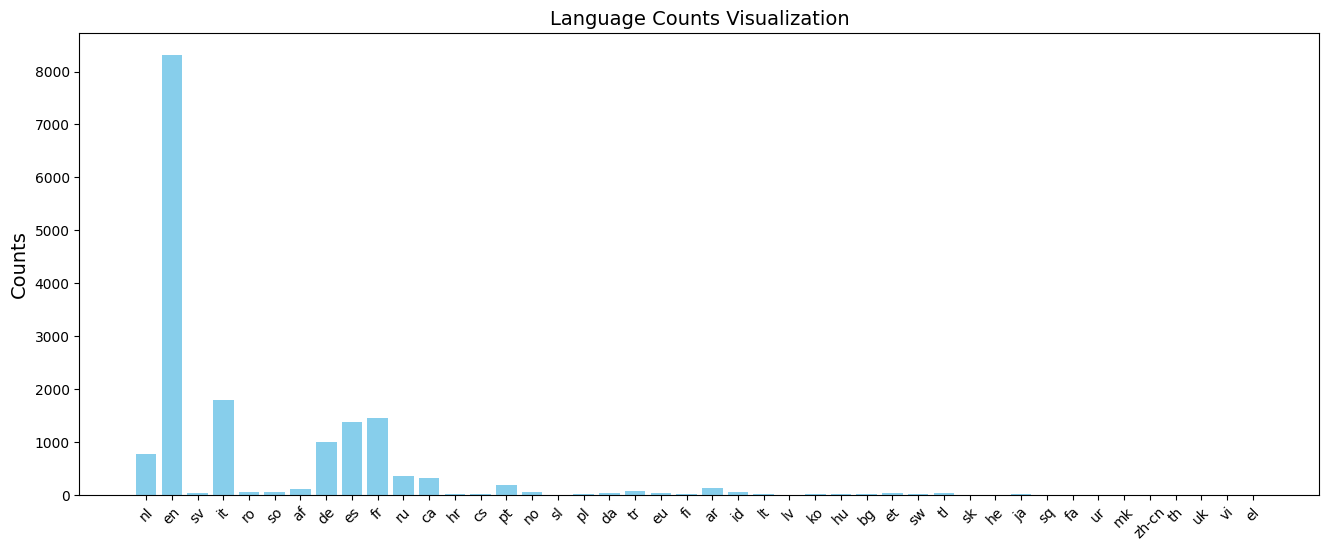

In [22]:
# Remove keys that are False or nan
keys_to_remove = [False, np.nan]
for key in keys_to_remove:
    if key in language_counts:
        del language_counts[key]

# Remove string representations of False and nan
if 'False' in language_counts:
    del language_counts['False']
if 'nan' in language_counts:
    del language_counts['nan']

# Extract data for plotting
languages = list(language_counts.keys())
counts = list(language_counts.values())

# Plotting the data
plt.figure(figsize=(16, 6))
plt.bar(languages, counts, color='skyblue')
# plt.xlabel('Languages', fontsize=12)
plt.ylabel('Counts', fontsize=14)
plt.title('Language Counts Visualization', fontsize=14)
plt.xticks(rotation=45)
# plt.show()
plt.savefig('lang_counts.png')

In [23]:
for i in our:
    if i in mlt:
        pass
        print('supported', end='\t')
        print(i, end='\t')
        print(freq[i])
    else:
        print('not supported', end='\t')
        print(i, end='\t')
        print(freq[i])

not supported	no	58
supported	af	115
supported	ar	133
supported	tr	68
supported	ur	4
supported	vi	6
supported	ko	13
not supported	el	3
supported	sw	12
supported	fa	4
not supported	hu	15
not supported	bg	10
supported	ro	65
supported	mk	6
supported	ru	358
supported	th	3
supported	sl	8
supported	sv	28
supported	fi	27
not supported	ca	328
not supported	zh-cn	8
supported	es	1380
supported	pt	196
not supported	da	40
supported	nl	778
not supported	eu	29
supported	id	56
supported	cs	12
supported	fr	1447
supported	uk	4
not supported	so	58
not supported	sk	6
not supported	False	70
supported	he	5
supported	en	8314
supported	it	1794
not supported	nan	132
supported	ja	13
supported	lv	6
supported	tl	44
supported	pl	21
supported	et	39
supported	lt	10
supported	hr	16
supported	de	1002
not supported	sq	5


# Load the MT model

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt").to(device)
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# Translate the reviews not in english

In [ ]:
out_list = []

for i in tqdm(range(len(df))):
    cur_row = df.iloc[i]
    cur_lang = cur_row['language']
    cur_text = cur_row['text']
    if cur_lang == 'en':
        out_list.append(cur_text)
    elif cur_lang in mlt:
        # translate from cur_lang to English
        tokenizer.src_lang = f"{cur_lang}_{cur_lang.upper()}"
        encoded_ar = tokenizer(cur_text, return_tensors="pt").to(device)
        generated_tokens = model.generate(
            **encoded_ar,
            forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"]
        )
        translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        out_list.append(translation[0])
    else:
        out_list.append(None)

# Export the resulting dataframe with translations

In [ ]:
df['tr'] = out_list
df.to_csv('out_wit_tra2.csv', encoding='utf-8')